In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


# Libraries

In [2]:
from collections import defaultdict
from typing import DefaultDict, List, Hashable, Dict, Any

from src.pipeline.dataloader import DataLoader

import pandas as pd
import numpy as np

import cobra
from cobra.util import create_stoichiometric_matrix
from cobra.core import Reaction

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from more_itertools import flatten
import math


In [3]:
path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


# Data preperation

In [4]:
DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
protein_metabolite_df = dl.get_simple_protein_metabolite_dataframe()
ENZYMES = protein_metabolite_df.to_df().columns.to_list()

METABOLITES = protein_metabolite_df.obs.columns.to_list()
METABOLITES = list(flatten(map(lambda x: str.split(x, ';'), METABOLITES)))

PRECURSOR_METABOLITES = [
    'g6p;g6p-B', 'g6p;f6p;g6p-B', 'f6p', 'dhap', '3pg;2pg',
    'pep', 'pyr', 'r5p', 'e4p', 'accoa', 'akg', 'oaa',
]
PRECURSOR_METABOLITES = list(flatten(map(lambda x: str.split(x, ';'), PRECURSOR_METABOLITES)))

PRECURSOR_METABOLITES_NO_TRANSFORM = [
    'f6p', 'dhap'
    'pep', 'pyr', 'r5p', 'e4p', 'accoa', 'akg', 'oaa',
]

def get_gene_reaction():
    gene_to_reaction: DefaultDict[str, List[str]] = defaultdict(list)
    reaction_to_gene: DefaultDict[str, List[str]] = defaultdict(list)

    for gene in model.genes:
        if gene.id not in ENZYMES:
            continue

        for reaction in gene.reactions:
            gene_to_reaction[gene.id].append(reaction.id)
            reaction_to_gene[reaction.id].append(gene.id)
    return gene_to_reaction, reaction_to_gene

def is_precursor_metabolite(
    metabolite_model_id: str,
    valid_metabolites: List[str],
):
    for precursor_metabolite in valid_metabolites:
        if precursor_metabolite in metabolite_model_id:
            yield precursor_metabolite

def get_matching_precursor_metabolite(
    cobra_metabolite_id: str,
    valid_metabolites: List[str],
):
    for precursor_metabolite in valid_metabolites:
        if precursor_metabolite in cobra_metabolite_id:
            return precursor_metabolite

def get_edge_list(valid_metabolites):
    precursor_model_metabolites = list(filter(lambda x: any((pc_meta in x.id for pc_meta in valid_metabolites)), model.metabolites))
    precursor_model_metabolites_id = list(map(lambda x: x.id, precursor_model_metabolites))
    print(f"{precursor_model_metabolites_id=}")


    precursor_stiochiometric_df: pd.DataFrame = create_stoichiometric_matrix(model, array_type="DataFrame").loc[precursor_model_metabolites_id]
    precursor_stiochiometric_df = precursor_stiochiometric_df.loc[:, (precursor_stiochiometric_df != 0).any(axis=0)]

    print(f"{precursor_stiochiometric_df.index.to_list()=}")

    gene_to_reaction, reaction_to_gene = get_gene_reaction()

    precursor_reactions = list(map(lambda x: (reaction_to_gene[x], precursor_stiochiometric_df[x].values), precursor_stiochiometric_df.columns.to_list()))
    precursor_reactions = [(enzyme, stiochiometrie) for enzymes, stiochiometrie in precursor_reactions for enzyme in enzymes]

    edge_list_df = pd.DataFrame.from_records(precursor_reactions).T
    edge_list_df = edge_list_df.explode(edge_list_df.columns.to_list()).set_axis(edge_list_df.iloc[0], axis=1)
    edge_list_df = edge_list_df.drop(0).set_index(precursor_stiochiometric_df.index).groupby(edge_list_df.columns, axis=1).sum()
    edge_list_df['metabolite_id'] = [get_matching_precursor_metabolite(cobra_metabolite_id, valid_metabolites) for cobra_metabolite_id in edge_list_df.index]
    edge_list_df = edge_list_df.groupby('metabolite_id').sum()
    edge_list_df = edge_list_df.stack().rename_axis(['metabolite_id', 'enzyme']).rename("cardinality")
    edge_list_df = edge_list_df[edge_list_df != 0].reset_index()

    join_list = [
        {"nodes_to_join": ['2pg', '3pg'], "joined_name": "3pg;2pg"},
        {"nodes_to_join": ['g6p', 'g6p-B'], "joined_name": "g6p;g6p-B"},
        # {"nodes_to_join": ['g6p', 'f6p', 'g6p-B'], "joined_name": "g6p;f6p;g6p-B"},
    ]

    for join_item in join_list:
        edge_list_df = edge_list_df.apply(lambda x: x.replace({node: join_item['joined_name'] for node in join_item['nodes_to_join']}, regex=True))

    return edge_list_df

In [5]:
with open('cobra_metabolites', 'w') as f:
    f.write('\n'.join(create_stoichiometric_matrix(model, array_type="DataFrame").index.to_list()))

# Unfilterd precursor based graph

precursor_model_metabolites_id=['2dr5p_c', '1pyr5c_c', '1pyr5c_m', '2cpr5p_c', 'akg_c', 'akg_e', 'akg_m', 'akg_n', 'akg_x', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'f6p_c', 'e4p_c', 'e4p_m', 'indpyr_c', 'itaccoa_m', 'oaa_c', 'oaa_e', 'oaa_m', 'oaa_x', 'pyr_c', 'pyr_e', 'pyr_m', 'pyr_x', 'phpyr_c', 'r5p_c']
precursor_stiochiometric_df.index.to_list()=['2dr5p_c', '1pyr5c_c', '1pyr5c_m', '2cpr5p_c', 'akg_c', 'akg_e', 'akg_m', 'akg_n', 'akg_x', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'f6p_c', 'e4p_c', 'e4p_m', 'indpyr_c', 'itaccoa_m', 'oaa_c', 'oaa_e', 'oaa_m', 'oaa_x', 'pyr_c', 'pyr_e', 'pyr_m', 'pyr_x', 'phpyr_c', 'r5p_c']


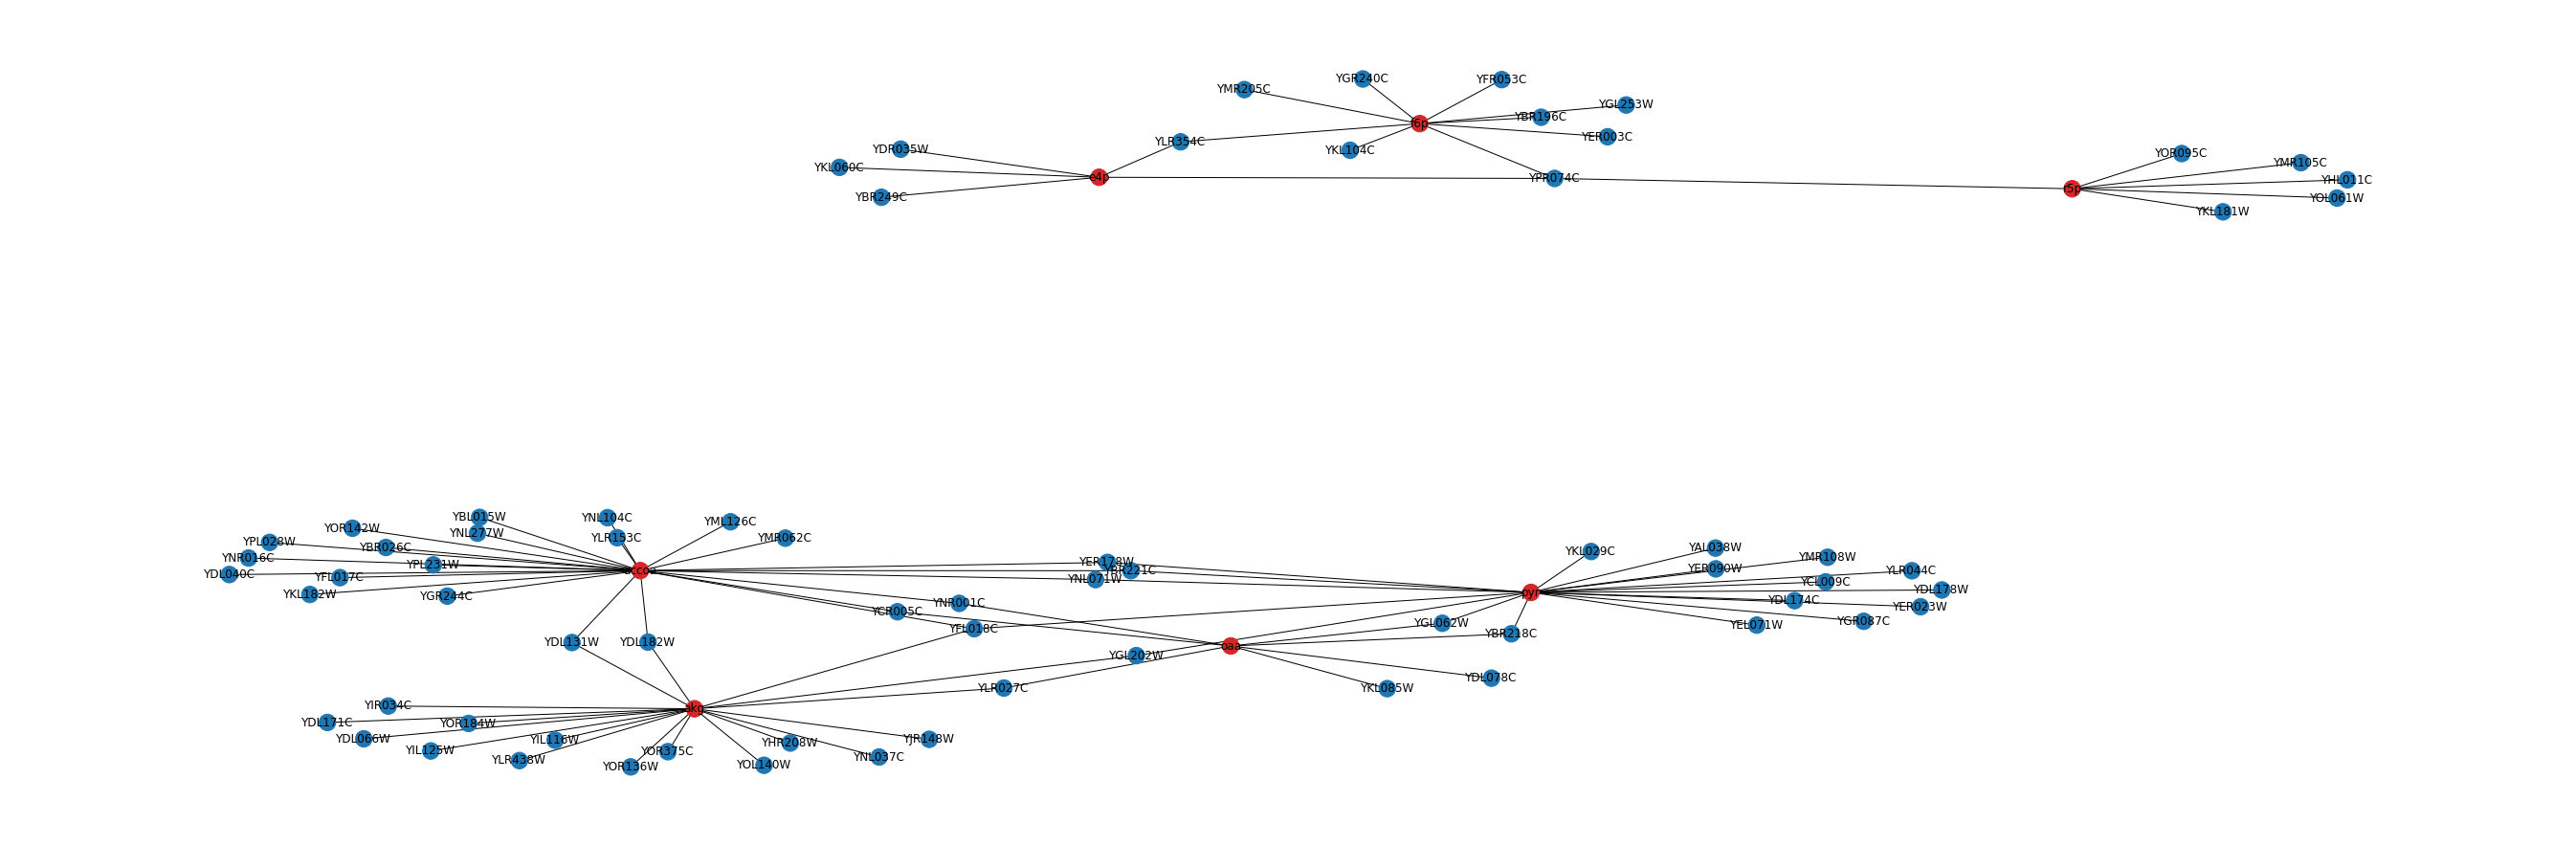

In [6]:
edge_list_df_unfiltered = get_edge_list(PRECURSOR_METABOLITES_NO_TRANSFORM)
edge_list_df_unfiltered.to_csv('./data/training/edge_list_unfiltered.csv')

G = nx.from_edgelist(
    zip(edge_list_df_unfiltered['metabolite_id'], edge_list_df_unfiltered['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]
node_size = np.random.randint(10, size=len(G)) * 100


fig, (ax1) = plt.subplots(1, 1, figsize=(48, 16))

pos = nx.fruchterman_reingold_layout(G)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    ax=ax1
)

# Strict precursor based graph

precursor_model_metabolites_id=['2dr5p_c', '2pg_c', '1pyr5c_c', '1pyr5c_m', '2cpr5p_c', '2doxg6p_c', '3pg_c', 'akg_c', 'akg_e', 'akg_m', 'akg_n', 'akg_x', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'apep_c', 'dhap_c', 'dhap_m', 'f6p_c', 'e4p_c', 'e4p_m', 'g6p_B_c', 'g6p_c', 'g6p_r', 'indpyr_c', 'itaccoa_m', 'oaa_c', 'oaa_e', 'oaa_m', 'oaa_x', 'pep_c', 'tag6p__D_c', 'pep_m', 'pepd_c', 'pepd_e', 'pyr_c', 'pyr_e', 'pyr_m', 'pyr_x', 'phpyr_c', 'r5p_c']
precursor_stiochiometric_df.index.to_list()=['2dr5p_c', '2pg_c', '1pyr5c_c', '1pyr5c_m', '2cpr5p_c', '2doxg6p_c', '3pg_c', 'akg_c', 'akg_e', 'akg_m', 'akg_n', 'akg_x', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'apep_c', 'dhap_c', 'dhap_m', 'f6p_c', 'e4p_c', 'e4p_m', 'g6p_B_c', 'g6p_c', 'g6p_r', 'indpyr_c', 'itaccoa_m', 'oaa_c', 'oaa_e', 'oaa_m', 'oaa_x', 'pep_c', 'tag6p__D_c', 'pep_m', 'pepd_c', 'pepd_e', 'pyr_c', 'pyr_e', 'pyr_m', 'pyr_x', 'phpyr_c', 'r5p_c']


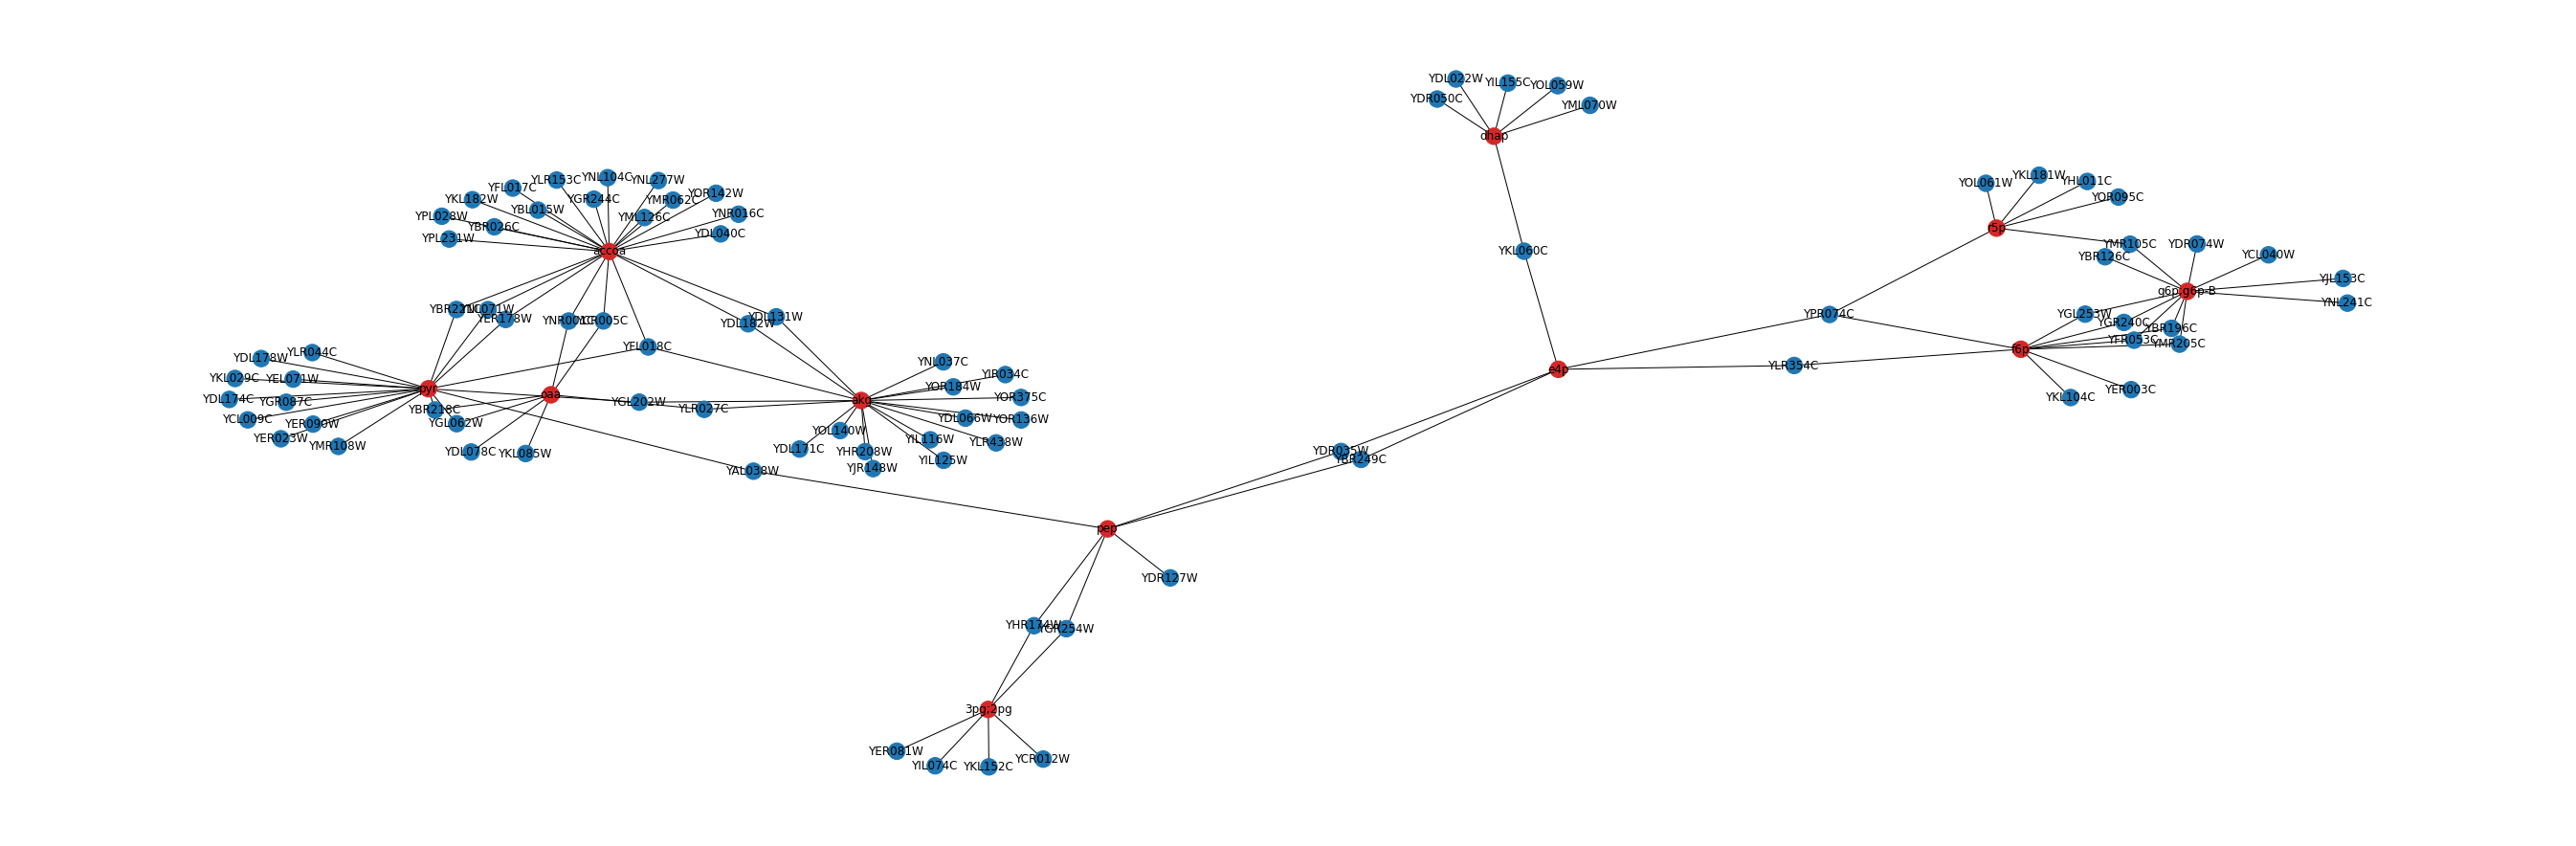

In [7]:
edge_list_df_strict = get_edge_list(PRECURSOR_METABOLITES)
edge_list_df_strict.to_csv('./data/training/edge_list_strict.csv')

G = nx.from_edgelist(
    zip(edge_list_df_strict['metabolite_id'], edge_list_df_strict['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]
node_size = np.random.randint(10, size=len(G)) * 100


fig, (ax1) = plt.subplots(1, 1, figsize=(48, 16))

pos = nx.fruchterman_reingold_layout(G)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    ax=ax1
)

# All metabolites

precursor_model_metabolites_id=['2dr5p_c', '2mcit_m', '2oxoadp_c', '2oxoadp_m', '2pg_c', '4fumacac_c', '35cdamp_c', '13dampp_c', '1ag3p_SC_c', '1agly3p_SC_c', '1pyr5c_c', '1pyr5c_m', '23camp_c', '3ig3p_c', '2cpr5p_c', '2doxg6p_c', '6pgc_c', 'acorn_m', 'L2aadp6sa_c', 'L2aadp_c', '3pg_c', 'adp_c', 'adp_g', 'adp_m', 'adp_n', 'adp_v', 'adp_x', 'adprib_c', 'adprib_m', '4ampm_c', 'atp_n', 'akg_c', 'akg_e', 'akg_m', 'atp_v', 'akg_n', 'atp_x', 'b124tc_m', 'akg_x', 'btamp_c', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'camp_c', 'amp2p_c', 'amp_c', 'amp_m', 'amp_n', 'amp_x', 'apep_c', 'cgly_c', 'dcamp_c', 'cit_c', 'cit_e', 'cit_m', 'cit_x', 'citr__L_c', 'atp_c', 'atp_g', 'atp_m', 'dhap_c', 'dhap_m', 'f6p_c', 'fdp_c', 'dadp_c', 'dadp_n', 'damp_c', 'datp_c', 'e4p_c', 'fum_c', 'e4p_m', 'eig3p_c', 'fum_e', 'fum_m', 'glyc3p_c', 'g3p_c', 'g3pc_c', 'g3pc_e', 'glyc3p_m', 'g3pi_c', 'glyc_c', 'g3pi_e', 'g6p_B_c', 'glyc_e', 'g6p_c', 'g6p_r', 'glycogen_c', 'glycogen_v', 'glytrna_c', 'ethamp_c', 'icit_c', '

/tmp/ipykernel_11096/791017993.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  edge_list_df['metabolite_id'] = [get_matching_precursor_metabolite(cobra_metabolite_id, valid_metabolites) for cobra_metabolite_id in edge_list_df.index]


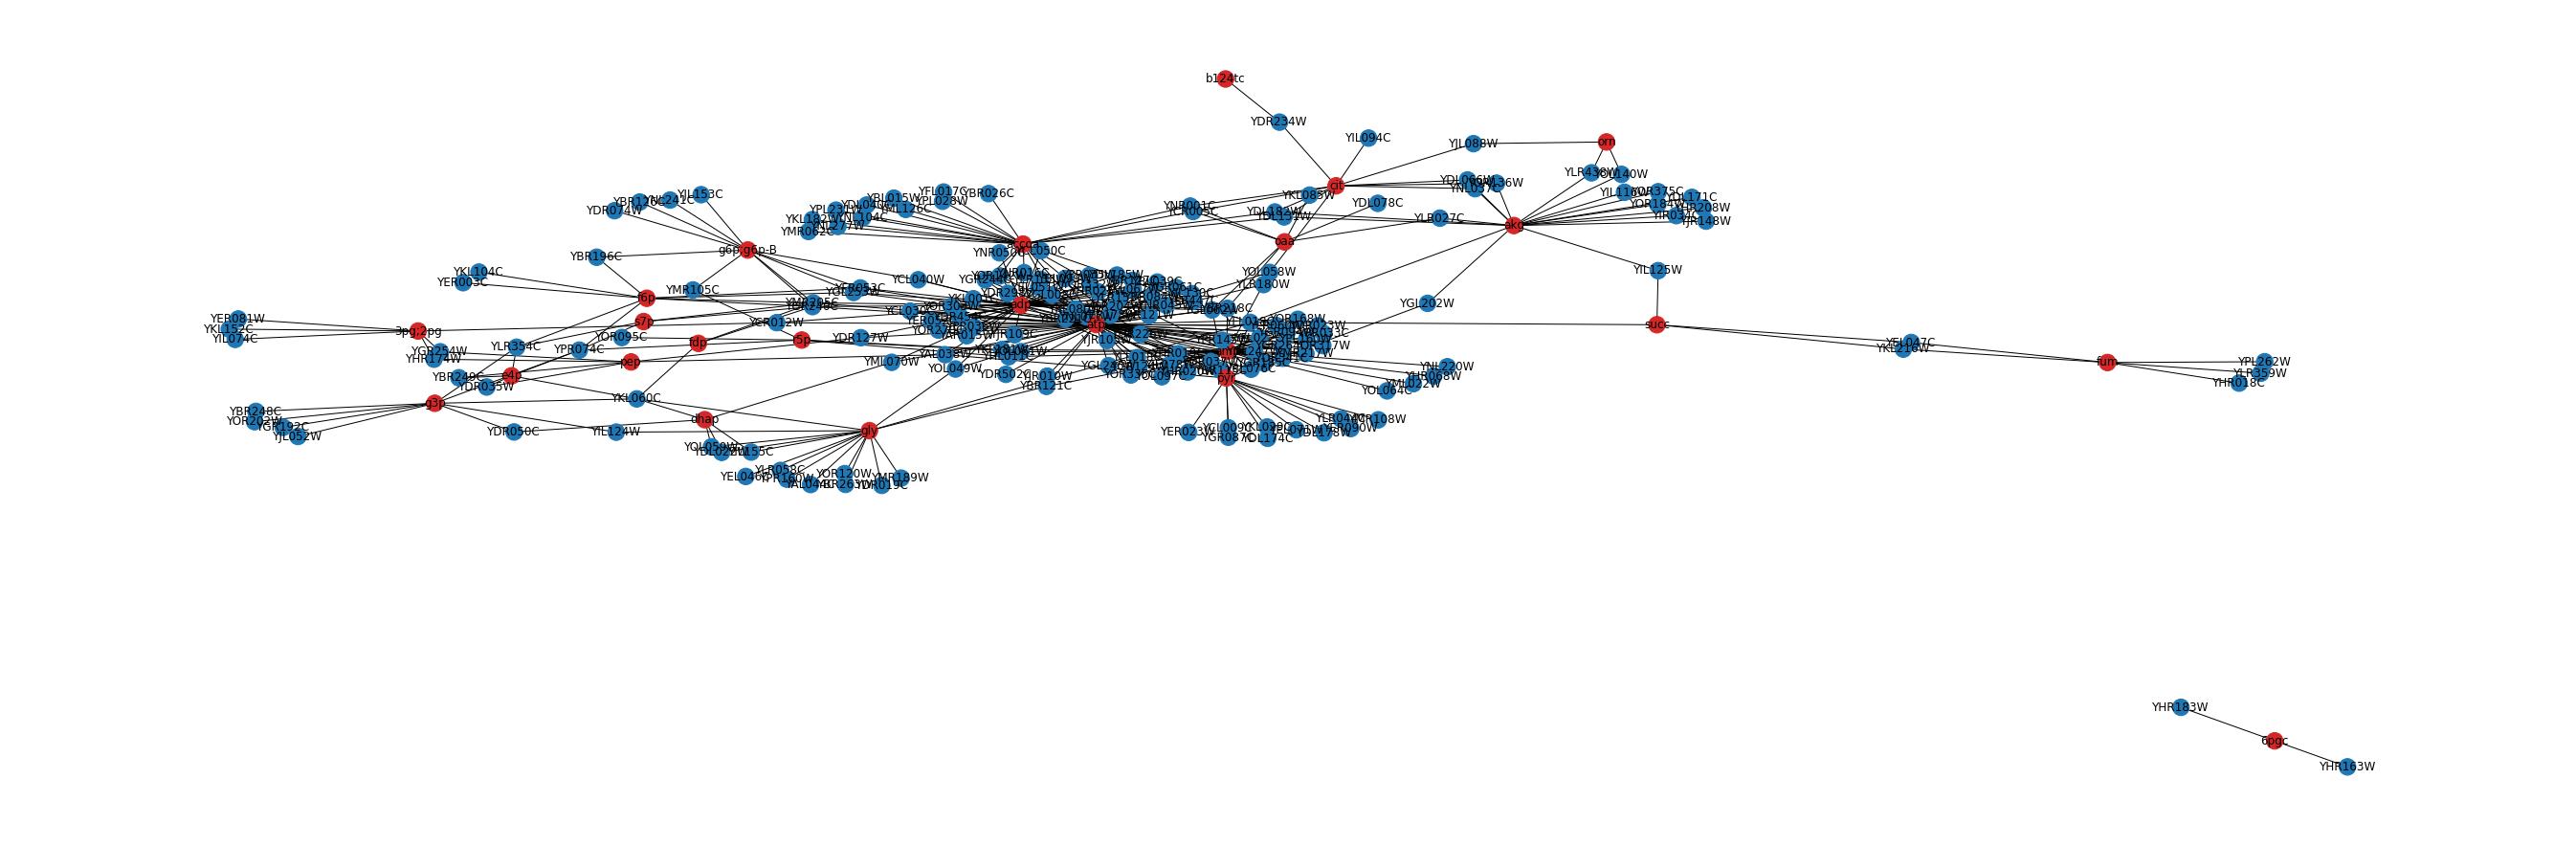

In [8]:
edge_list_df_all = get_edge_list(METABOLITES)
edge_list_df_all.to_csv('./data/training/edge_list_all.csv')

G = nx.from_edgelist(
    zip(edge_list_df_all['metabolite_id'], edge_list_df_all['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]

fig, (ax1) = plt.subplots(1, 1, figsize=(48, 16))

pos = nx.fruchterman_reingold_layout(G)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    ax=ax1
)

# Some overall features foreach graph

In [9]:
def plot_graph_information(G, graph_title, idx, column_width, fig, axgrid):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    lower_column_boundary = idx * column_width
    middle_column_bondary = lower_column_boundary + math.floor(column_width / 2)
    upper_column_bondary = (idx + 1) * column_width

    ax0 = fig.add_subplot(axgrid[:3, lower_column_boundary:upper_column_bondary])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in Gcc]
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_color=color_map, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title(f"Connected components of G ({graph_title})")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, lower_column_boundary:middle_column_bondary])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    df = pd.DataFrame({
        "degree": np.unique(degree_sequence, return_counts=True)[0],
        "total": np.unique(degree_sequence, return_counts=True)[1],
        "metabolite": np.unique(degree_sequence, return_counts=True)[1],
        "enzyme": np.unique(degree_sequence, return_counts=True)[1],
    })

    ax2 = fig.add_subplot(axgrid[3:, middle_column_bondary:upper_column_bondary])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()

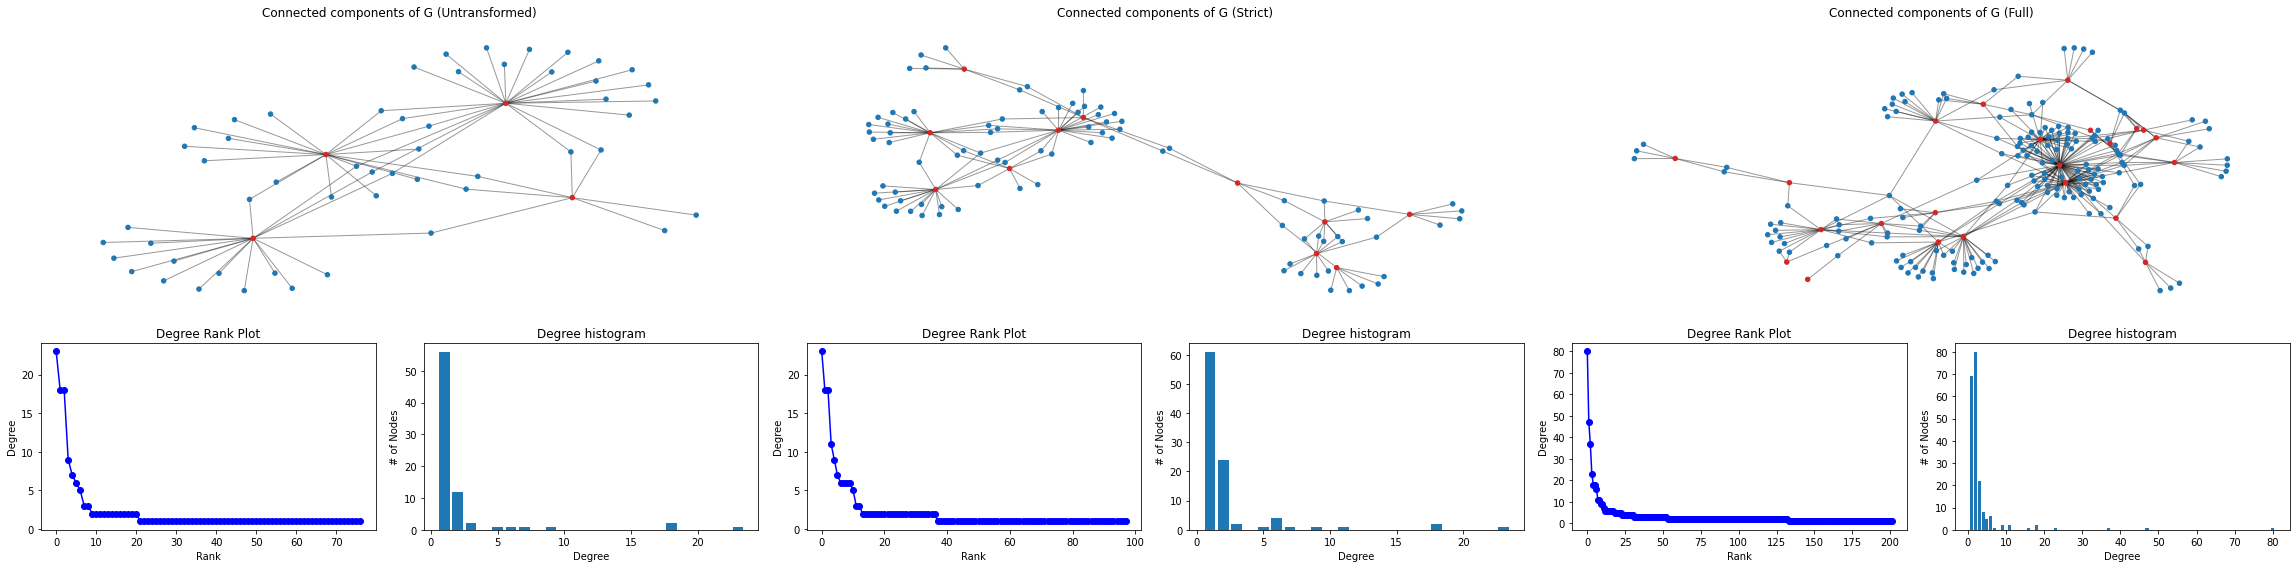

In [10]:
Gs = [
    nx.from_edgelist(zip(edge_list_df_unfiltered['metabolite_id'], edge_list_df_unfiltered['enzyme'])),
    nx.from_edgelist(zip(edge_list_df_strict['metabolite_id'], edge_list_df_strict['enzyme'])),
    nx.from_edgelist(zip(edge_list_df_all['metabolite_id'], edge_list_df_all['enzyme'])),
]

G_titles = [
    'Untransformed',
    'Strict',
    'Full'
]

fig = plt.figure("Degree of a random graph", figsize=(32, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 12)

for idx, (G, G_title) in enumerate(zip(Gs, G_titles)):
    plot_graph_information(G, G_title, idx, 4, fig, axgrid)

plt.show()